In [117]:
import os
import sys
import cv2
import importlib
import numpy as np
import math
import mrcnn.model as modellib
import importlib


from mrcnn.config import Config


ROOT_DIR = os.path.abspath(".")

#####################################
color = False
dir = "Bar3_6" 

image_num = 1
min_num_obj = 3
max_num_obj = 6
############################################

datasetGenerator = importlib.import_module(dir + '.Dataset_generator')
ICRN_config_dir = importlib.import_module(dir + '.ICRNConfigure')
ICRN_config = ICRN_config_dir.Config()
ICRN_model = datasetGenerator = importlib.import_module(dir + '.Net_IRNm').Build_IRN_m_Network()


if color == True:
    RCNNMODEL_DIR = os.path.join(ROOT_DIR, "MaskRCNNlogs/BarChart_color")
    channel = 3
else:
    RCNNMODEL_DIR = os.path.join(ROOT_DIR, "MaskRCNNlogs/BarChart_color/logs_bargrayscale")
    channel = 1


# Load Mask RCNN 


class ShapesConfig(Config):

    NAME = "CQA"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    NUM_CLASSES = 1 + 1  

    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  

    TRAIN_ROIS_PER_IMAGE = 32

    STEPS_PER_EPOCH = 100

    VALIDATION_STEPS = 5
    
maskrcnnconfig = ShapesConfig()
maskrcnnconfig.display()


class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

maskrcnn_model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=RCNNMODEL_DIR)

maskrcnn_model_path = maskrcnn_model.find_last()

# Load trained weights
maskrcnn_model.load_weights(maskrcnn_model_path, by_name=True)

##############################################################
# generate images




Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [106]:
GenerateOneBarChart = datasetGenerator.GenerateOneBarChart

_images = np.ones((ICRN_config.max_obj_num, image_num, ICRN_config.image_height, ICRN_config.image_width, channel), dtype='float32')
_labels = []
number_of_bars = []


def get_segmented_image(segments_bbs, image):
    
    removed_image = image.copy()
    for i in range(len(segments_bbs)):
        toremovesegment = segments_bbs[i]
    
        x1 = toremovesegment[0]
        y1  = toremovesegment[2]
        x2 = toremovesegment[1]
        y2 = toremovesegment[3]

        removed_image[x1 : y1, x2 : y2] = (1, 1, 1)
        removed_image[x1 : y1, x2 : y2] =removed_image[x1 : y1, x2 : y2] +  np.random.uniform(0, 0.05, (abs(y1-x1), abs(y2-x2),3))
        _min = 0.0  # because the image is not 0/1 black-and-white image, is a RGB image.
        _max = removed_image.max()
        removed_image -= _min
        removed_image[x1 : y1, x2 : y2] /= (_max - _min)
   
    return removed_image


def get_segmented_image_grayscale(segments_bbs, image):
    
    padding = 2
    removed_image = image.copy()
    for i in range(len(segments_bbs)):
        toremovesegment = segments_bbs[i]
    
        x1 = toremovesegment[0]
        y1  = toremovesegment[2]
 
        x2 = toremovesegment[1]
        y2 = toremovesegment[3]

        y1 = 100
        removed_image[0 : y1, x2-padding : y2+padding ] = (1, 1, 1)
        removed_image[0 : y1, x2-padding : y2+padding ] =removed_image[0 : y1, x2-padding : y2+padding ] +  np.random.uniform(0, 0.05, (abs(y1), abs(y2-x2 + padding + padding),3))
        _min = 0.0  
        _max = removed_image.max()
        removed_image -= _min
        removed_image[0 : y1, x2-padding : y2+padding ] /= (_max - _min)
   
    removed_image_gray_scale = removed_image[:,:,1:2]

    return removed_image_gray_scale


for i in range(image_num):

        image, _, featureVector = GenerateOneBarChart(
                num=np.random.randint(min_num_obj, max_num_obj + 1))
        
        featureVector = np.array(featureVector)
        
        color_img = np.zeros((image.shape[0], image.shape[1], 3))

        if color is False:
            color_img[:,:,0] = image[:,:,0]
            color_img[:,:,1] = image[:,:,0]
            color_img[:,:,2] = image[:,:,0]
            results = maskrcnn_model.detect([color_img], verbose=1)

        else:
            results = maskrcnn_model.detect([image], verbose=1)

           # image = color_img

        r = results[0]
        arr = r['rois']
        segments_bbs = arr[arr[:,1].argsort()]

        segments = []
        for p in range(len(r['rois'])):
            if color is True:
                segments.append(get_segmented_image([x for x in segments_bbs if ((x != segments_bbs[p]).any())], image))
            else:
                segments.append(get_segmented_image_grayscale([x for x in segments_bbs if ((x != segments_bbs[p]).any())], color_img))

            
        subImages = [np.ones(shape=(ICRN_config.image_width,ICRN_config.image_width,channel)) for i in range(max_num_obj)]
        for count in range(len(r['rois'])):

            if count< max_num_obj:
                subImages[count] = segments[count]
            
        for t in range(max_num_obj):
            _images[t][i] = subImages[t]

        number_of_bars.append(len(r['rois']))
        
        label = np.zeros(max_num_obj, dtype='float32')
        label[:len(featureVector)] = featureVector
        _labels.append(label)
        
_labels = np.array(_labels, dtype='float32')






# Image generation 

# Segment data based on mask 

# get test data 


# load the ICRN model 
# load RN model 
# load VGG model 
# load other model 


# predict 

# save results 







Processing 1 images
image                    shape: (100, 100, 3)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 128, 128, 3)      min: -123.69858  max: -102.90113  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


In [128]:
from keras.optimizers import SGD, Adam

m_optimizer = Adam(0.0001)
ICRN_model.compile(loss='mse', optimizer=m_optimizer)



NameError: name 'ICRN_model' is not defined

In [131]:
GenerateOneBarChart = datasetGenerator.GenerateOneBarChart()


TypeError: GenerateOneBarChart() missing 1 required positional argument: 'num'

In [130]:
ICRNModelPath = os.path.join(ROOT_DIR, "results/ICRN/BarColor")
model.load_weights(ICRNModelPath + '/Barchart_color.h5')

NameError: name 'model' is not defined

In [107]:
subImages[0].shape

(100, 100, 1)

In [108]:
segments[0].shape

(100, 100, 1)

In [109]:
image.shape

(100, 100, 1)

In [110]:
import matplotlib.pyplot as plt

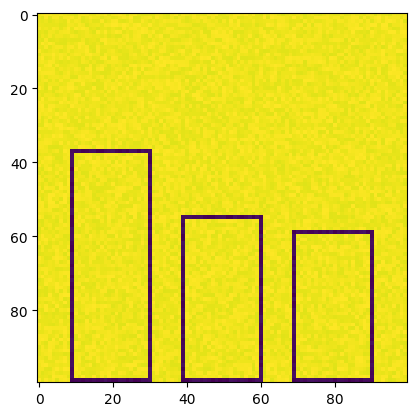

In [111]:
plt.imshow(image)

In [112]:
segments[0].shape

(100, 100, 1)

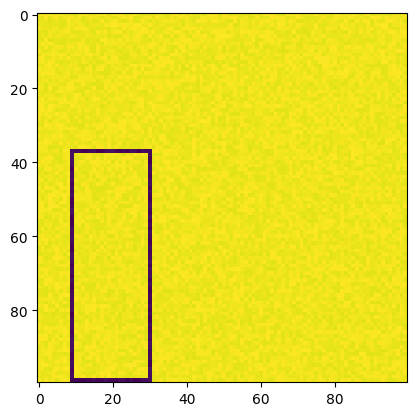

In [114]:
plt.imshow(segments[0])

In [191]:
segments[5].shape

IndexError: list index out of range

In [180]:
channel_1 = segments[5][:,:,1:2]



In [181]:
channel_1.shape

(100, 100, 0)

TypeError: Invalid shape (100, 100, 0) for image data

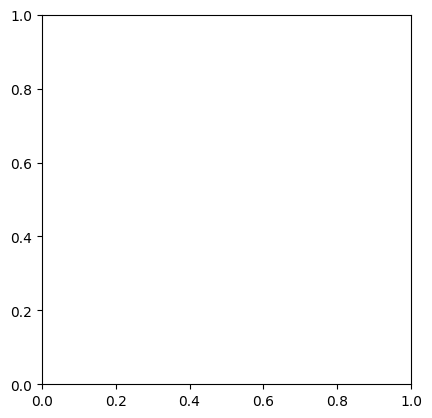

In [182]:
plt.imshow(channel_1)